In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib as ta
from copy import copy
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
from ta_suite import ta_suite
from ta_signals import ta_signals
from trading import act
from trading import pnl_profile

In [3]:
nifty = pd.read_csv(r"C:\Users\1987h\Downloads\Data science, machine learning and Quant Trading\algorithmic trading\GetZerodhaData\NIFTY 50.csv")

In [4]:
tt = ta_suite(nifty)
df = tt.combine()

In [5]:
# features
features = ['Slowk', 'Slowd','BandSplit_2','BRatio_2','RSI', 'ema_50_21', 'ema_100_50',
       'ema_200_100', 'CCI', 'ATR','SAR', 'CORR','returns']

#preparing the data for training and testing
X = df[features]
y = df['future returns(classifier)']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,shuffle=False)

In [6]:
scaler = StandardScaler()
svc = svm.SVC()

pipe = Pipeline([("scaler", scaler), ("classifier", svc)])

In [12]:
param_grid = {"classifier__gamma":np.logspace(-2,2,10),
             "classifier__C":np.logspace(-2,2,10)}

random_search = RandomizedSearchCV(pipe,param_grid,cv=3,n_jobs=-1,n_iter=10,verbose=1)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'classifier__gamma': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02]), 'classifier__C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [13]:
random_search.best_params_

{'classifier__gamma': 0.0774263682681127, 'classifier__C': 1.6681005372000592}

best_params

{'classifier__gamma': 0.0774263682681127, 'classifier__C': 1.6681005372000592}

In [16]:
y_pred = random_search.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred)

0.5439122393009759

No handles with labels found to put in legend.


nan
nan


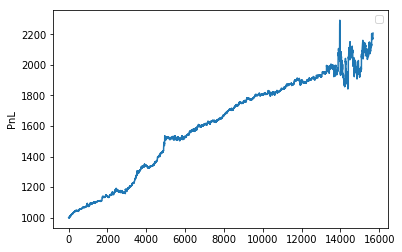

In [18]:
X,pnl = pnl_profile(X_test,y_pred)

# KERNEL APPROXIMATION (for faster training)

In [7]:
from sklearn.kernel_approximation import Nystroem
from tempfile import mkdtemp
from shutil import rmtree
scaler = StandardScaler()
svc = svm.SVC()

In [9]:
kernel_approx = Nystroem(kernel='rbf', n_components=100, random_state=0)
clf = svm.LinearSVC()

cachedir = mkdtemp()
pipe = Pipeline([('scaler',scaler),
                ('projection',kernel_approx),
                ('classifier',clf)], memory=cachedir)
param_grid = {"projection__gamma":np.logspace(-2,2,100),
             "classifier__C":np.logspace(-2,2,100)}
random_search = RandomizedSearchCV(pipe,param_grid,cv=5,n_jobs=-1,n_iter=50,verbose=1,random_state=0)
random_search.fit(X_train,y_train)
rmtree(cachedir)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.7min finished


In [10]:
split = int(.8*X_test.shape[0])
random_search.score(X_test[split:],y_test[split:])

0.5095663265306123

In [11]:
y_pred = random_search.predict(X_test[split:])
accuracy_score(y_test[split:], y_pred)

0.5095663265306123

No handles with labels found to put in legend.


nan
nan


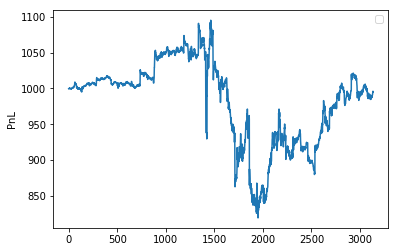

In [12]:
X,pnl = pnl_profile(X_test[split:],y_pred)